In [1]:
# install requirements
# !pip install -r requirements.txt

### 2. EDA Watershed challenge
we will perform the EDA mainly searching for nulls and exploring the dataset variables and their relationships, we use the `dtale` library to perform most of the exploration, but we only keep the major highlights. 

In [2]:
import pandas as pd
import dtale

flux_df = pd.read_csv('challenge_watershed/flux.csv') # parse_dates=['date']
flux_df.head()

date  basin_id   flux  precip   temp_max                 gauge_name  \
0  1980-01-01   1001001  0.579     0.0  10.685653  Rio Caquena En Nacimiento   
1  1980-01-02   1001001  0.543     0.0  11.470960  Rio Caquena En Nacimiento   
2  1980-01-03   1001001  0.482     0.0  11.947457  Rio Caquena En Nacimiento   
3  1980-01-04   1001001  0.459     0.0  12.424489  Rio Caquena En Nacimiento   
4  1980-01-05   1001001  0.436     0.0  12.649203  Rio Caquena En Nacimiento   

       lat      lon    mean_elev   area_km2  
0 -18.0769 -69.1961  4842.449328  49.711859  
1 -18.0769 -69.1961  4842.449328  49.711859  
2 -18.0769 -69.1961  4842.449328  49.711859  
3 -18.0769 -69.1961  4842.449328  49.711859  
4 -18.0769 -69.1961  4842.449328  49.711859

gauge_name                                    basin_id
Rio Aconcagua En Chacabuquito                 5410002     14670
Rio Cruces En Rucaco                          10134001    14649
Rio Choapa En Cuncumen                        4703002     14639
Rio Elqui En Algarrobal                       4320001     14634
Rio Cautin En Cajon                           9129002     14603
                                                          ...  
Estero Chimbarongo En Santa Cruz              6034001       328
Rio Chillan En Longitudinal                   8117001       302
Estero Las Vegas Aguas Abajo Canal Las Vegas  5423002       195
Rio Pama Entrada Embalse Cogoti               4534001       195
Rio Blanco En Chaiten                         10683002      175
Length: 503, dtype: int64


<AxesSubplot:ylabel='Frequency'>

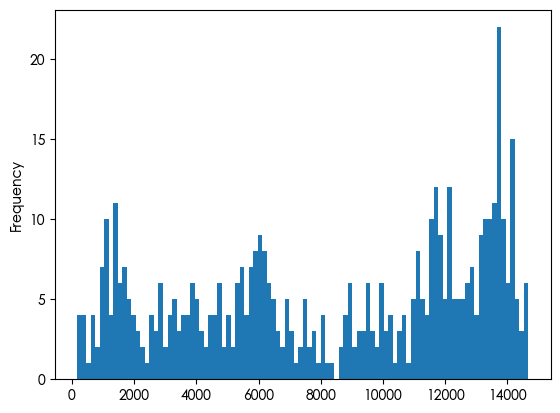

In [3]:
%matplotlib inline
# number of registers by station
print(flux_df[['gauge_name','basin_id']].value_counts())
# check id unique
# flux_df.groupby(['gauge_name','basin_id'])['basin_id'].nunique().sort_values()
# 
flux_df[['gauge_name','basin_id']].value_counts().plot.hist(bins=100)

As we can observe there are a few stations that had less than 2000 registers, that probably means that they have way less history than other stations, in the time series analysis we will probably will need to find a minimum common time-window where to use as much as possible from that data. 

Given that we need to perform some outlier/extreme_value analysis we want to have a fixed "panel" of stations as much as homogeneous as possible, for as wider-as-possible period. This mainly to detect some changes in the trend of outliers, and removing some inherent bias for the newer/fewer stations. we can plot the data timeline of the stations. 

In [4]:
import plotly.express as px
reg_period_df = flux_df.groupby('gauge_name', as_index=False).agg({'date':[min,max]})
reg_period_df.columns = ['_'.join(tup).rstrip('_') for tup in reg_period_df.columns.values]
reg_period_df.sort_values(by = ["date_min", "date_max"], inplace=True)

fig = px.timeline(reg_period_df, x_start="date_min", x_end="date_max", y="gauge_name", width=800, height=1400)

fig.show()

If we observe the timeline of registers by station, we observe that most of the stations have being recently added, most of them had being active the entire time, but some of them were deactivated a while ago. (this analysis is ignoring the missing data within the last and first register, but is still a good visualization to show the missing data).

We can use all the `basin_id` to fit a prediction model, but we need to be careful in the "change trend" analysis, specially because if we have a difference in the size/representation of the stations panel, we might misunderstand the effect of the time on the number of extreme events

In [47]:
# we can run a missing values analysis, but just to get if some variables are missing from the dataset in general
# nulls in dataset 
print('Number of nulls by column')
print(flux_df.isnull().sum(axis = 0))
# and by basin_id
print('Missing data percentage by basin_id')
nulls_df = flux_df.groupby("basin_id").apply(lambda x: x.notnull().mean()).sort_values(by='precip')
dtale.show(nulls_df[['precip','temp_max']])


Number of nulls by column
date             0
basin_id         0
flux             0
precip        5443
temp_max      5443
gauge_name       0
lat              0
lon              0
mean_elev        0
area_km2         0
date_ym          0
date_y           0
date_ts          0
dtype: int64
Missing data percentage by basin_id


Given that just the `basin_id` had some missing registers that are less than `3%` it is possible to do some imputation; using (linear) interpolation to fill the values, `ffill`/`bfill` etc. 

There are other values that might be missing as well, entire days for some `basin_id`. This will be particularly problematic on the prediction stage, nevertheless, we will do the "data imputation" on the prediction stage, and for simplicity we will drop the missing rows to understand other characteristics of the Dataset

#### 2.2 Geographical distribution of the stations

We now see how the stations are distributed geographically, this is important because they are very different in latitude therefore, they probably present very different precipitations and temperatures, plotting all the stations will help us to see if there is an inherent deviation if we subsample the panel. 

In [48]:
import plotly.express as px
flux_df['date_ym'] = flux_df['date'].str[:7]
flux_df['date_y'] = flux_df['date'].str[:4]

reg_month_df = flux_df.groupby(['basin_id', 'lat', 'lon','date_y'], as_index=False)['gauge_name'].count()
# reg_month_df

fig = px.scatter_geo(reg_month_df, 
                     #locations="iso_alpha", 
                     lat = 'lat',
                     lon = 'lon',
                     #color="continent",
                     hover_name="basin_id", 
                     size="gauge_name",
                     animation_frame="date_y",
                     scope="south america",
                     width=500, height=700,
                     size_max=5
                     )
fig.show()

The distribution seems steady overtime, there is an increase of stations in the south and in the center overtime, but in terms of the amount of data points doesn't seem very relevant, that's good news because that probably will provide us a representative sample of all the latitudes 

#### 3. Plot functions 
we add the requested functions 

In [49]:
## adding the plot functions for the stations 
from typing import Literal
import plotly.express as px
flux_df['date_ts'] = pd.to_datetime(flux_df['date'])

# first function 
def plot_one_timeserie(cod_station:int, variable:Literal['flux','precip','temp_max'], min_date:str, max_date:str) -> None:
    sub_df = flux_df[(flux_df['basin_id'] == cod_station) &
                     (flux_df['date'] >= min_date) &
                     (flux_df['date'] <= max_date)].copy()
    fig = px.line(sub_df, x='date_ts', y=variable)
    fig.show()
#test 
plot_one_timeserie(cod_station=7355001, 
                   variable='precip',
                   min_date='1998-01-01',
                   max_date='2022-12-12')

# second function 
def plot_three_timeseries(cod_station, min_date, max_date):

    sub_df = flux_df[(flux_df['basin_id'] == cod_station) &
                     (flux_df['date'] >= min_date) &
                     (flux_df['date'] <= max_date)][['flux','precip','temp_max','date_ts']].copy()
    # normalize variables
    cols = ['flux','precip','temp_max'] 
    sub_df[cols]=(sub_df[cols]-sub_df[cols].min())/(sub_df[cols].max()-sub_df[cols].min())
    fig = px.line(sub_df, x='date_ts', y=cols)
    fig.show()

#test 
plot_three_timeseries(cod_station=7355001, 
                      min_date='1998-01-01',
                      max_date='2022-12-12')



### 4. Extreme values 
we would like to know if the variables `(['flux','precip','temp_max'])` correspond to an extreme value (or, very unlikely value), there are several techniques to infer how unlikely the values that we are seeing, some of them more complex than others:

1. We can assume that all the observations from each variable (`temperatures, precip, flux`) come from one single distribution (by station), then we can identify how unlikely is one observation to estimate the probability of the posterior (or, even more simplistic, the percentile). The limitation of this approach is that we will prompt to ignore the seasonality effects, and an extreme temperature in winter might be just a regular temperature in summer, to solve that we can implement a second approach  

2. We can split the observations into 4 season sets, and then use the same approach as (1). The limitation of this approach will appear on the borders of our sets because the seasons are just an arbitrary definition we are prompted to find outliers on the boundaries of our seasonal sets.

3. Another more complex approach is to use a model to predict the values trained on some past data (a few years), depending on how likely the observation from the prediction we flag it as an outlier, this will fix the seasonality problem, just because we can control by season (using the day of year or another variable to control for it). The limitation of this approach is that we will need to train the model at least with one part of the time series that we define as "normal", then from that point, we can predict and evaluate the probability.

There are many models that we can implement for outlier detection for time series, the simplest ones are [moving averages](https://www.mikulskibartosz.name/using-exponentially-weighted-moving-average-for-anomaly-detection/) or [moving medians](https://anomaly.io/anomaly-detection-moving-median-decomposition/index.html) and other more sophisticated [ts models](https://adtk.readthedocs.io/en/stable/index.html)

Particularly for this case, we will use a custom fit/predict using prophet, because it provides as a simple implementation whereas it also provides a probabilistic forecast approach. 

### Side Note
for the simplicity of the exercise, we are assuming that the `extreme` values are "station"-wise anomalies. Considering that the climate and weather might affect several near-stations, and therefore there should be a correlation between these extreme observations on near-stations too. With this information, we might be able to "cross-fit" our anomaly detection model using not only one station but the stations near it. That means that we might be able to understand if several flags are raised in the neighborhood, is more likely that we are observing an extreme event. 

For the sake of time, we will not deep dive into that 

In [51]:
from typing import List 
from prophet import Prophet
from prophet.diagnostics import generate_cutoffs
from others import suppress_stdout_stderr

cod_station = 5410002
sub_df = flux_df[(flux_df['basin_id'] == cod_station)][['flux','precip','temp_max','date_ts']].copy()

variable = 'flux'
ts_df = sub_df[['date_ts', variable]].copy()
ts_df.rename({'flux':'y',
              'date_ts':'ds'}, axis=1, inplace=True)
baseline_train_yrs = 3

test_size = 365 * 2
horizon = pd.Timedelta(f'{test_size} days')
period = horizon 
cuoffs_list = generate_cutoffs(ts_df, 
                               horizon=horizon,
                               period=period, 
                               initial=pd.Timedelta(f'{baseline_train_yrs*365} days'),
                              )
forecast_df_list:List[pd.DataFrame] = []
for cutoff_date in cuoffs_list:
    fold_ts_df = ts_df[ts_df['ds']<=cutoff_date].copy()

    with suppress_stdout_stderr():
        model = Prophet(n_changepoints = 0, 
                weekly_seasonality=False,
                interval_width=0.99
                )
        model.fit(fold_ts_df)
        future = model.make_future_dataframe(periods=test_size)
        forecast = model.predict(future)
    # remove outliers from ts_df
    next_fold_ds = ts_df[(ts_df['ds']> cutoff_date) & 
                         (ts_df['ds']<= cutoff_date +horizon)].copy()
    forecasted_fold_ds = pd.merge(next_fold_ds, forecast, how='left', on='ds')
    forecasted_fold_ds['anomaly_flag'] = ((forecasted_fold_ds['y'] > forecasted_fold_ds['yhat_upper'])  
                                          # | (forecasted_fold_ds['y'] < forecasted_fold_ds['yhat_lower']
                                          )
    forecast_df_list.append(forecasted_fold_ds)
    # remove outliers
    ts_df.loc[ts_df['ds'].isin(forecasted_fold_ds[forecasted_fold_ds['anomaly_flag']]['ds']), 'y'] = None 
    print(f'{cutoff_date = } num_outliers = {forecasted_fold_ds["anomaly_flag"].sum()}')
outliers_df = pd.concat(forecast_df_list)


2022-10-24 17:07:15,934 - INFO     - Making 18 forecasts with cutoffs between 1984-06-15 00:00:00 and 2018-06-07 00:00:00
2022-10-24 17:07:15,946 - INFO     - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
17:07:15 - cmdstanpy - INFO - Chain [1] start processing
2022-10-24 17:07:15,980 - INFO     - Chain [1] start processing
17:07:16 - cmdstanpy - INFO - Chain [1] done processing
2022-10-24 17:07:16,062 - INFO     - Chain [1] done processing
2022-10-24 17:07:16,699 - INFO     - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
17:07:16 - cmdstanpy - INFO - Chain [1] start processing
2022-10-24 17:07:16,739 - INFO     - Chain [1] start processing
17:07:16 - cmdstanpy - INFO - Chain [1] done processing
2022-10-24 17:07:16,820 - INFO     - Chain [1] done processing


cutoff_date = Timestamp('1984-06-15 00:00:00') num_outliers = 1


2022-10-24 17:07:17,750 - INFO     - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
17:07:17 - cmdstanpy - INFO - Chain [1] start processing
2022-10-24 17:07:17,792 - INFO     - Chain [1] start processing
17:07:17 - cmdstanpy - INFO - Chain [1] done processing
2022-10-24 17:07:17,910 - INFO     - Chain [1] done processing
17:07:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
2022-10-24 17:07:17,914 - ERROR    - Chain [1] error: error during processing Operation not permitted
2022-10-24 17:07:17,916 - WARNING  - Optimization terminated abnormally. Falling back to Newton.


cutoff_date = Timestamp('1986-06-15 00:00:00') num_outliers = 74


17:07:17 - cmdstanpy - INFO - Chain [1] start processing
2022-10-24 17:07:17,947 - INFO     - Chain [1] start processing
17:07:22 - cmdstanpy - INFO - Chain [1] done processing
2022-10-24 17:07:22,512 - INFO     - Chain [1] done processing
2022-10-24 17:07:23,336 - INFO     - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
17:07:23 - cmdstanpy - INFO - Chain [1] start processing
2022-10-24 17:07:23,382 - INFO     - Chain [1] start processing
17:07:23 - cmdstanpy - INFO - Chain [1] done processing
2022-10-24 17:07:23,523 - INFO     - Chain [1] done processing
17:07:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
2022-10-24 17:07:23,526 - ERROR    - Chain [1] error: error during processing Operation not permitted


cutoff_date = Timestamp('1988-06-14 00:00:00') num_outliers = 0


2022-10-24 17:07:23,527 - WARNING  - Optimization terminated abnormally. Falling back to Newton.
17:07:23 - cmdstanpy - INFO - Chain [1] start processing
2022-10-24 17:07:23,563 - INFO     - Chain [1] start processing
17:07:24 - cmdstanpy - INFO - Chain [1] done processing
2022-10-24 17:07:24,534 - INFO     - Chain [1] done processing
2022-10-24 17:07:25,448 - INFO     - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
17:07:25 - cmdstanpy - INFO - Chain [1] start processing
2022-10-24 17:07:25,498 - INFO     - Chain [1] start processing
17:07:25 - cmdstanpy - INFO - Chain [1] done processing
2022-10-24 17:07:25,627 - INFO     - Chain [1] done processing


cutoff_date = Timestamp('1990-06-14 00:00:00') num_outliers = 1


2022-10-24 17:07:26,627 - INFO     - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
17:07:26 - cmdstanpy - INFO - Chain [1] start processing
2022-10-24 17:07:26,685 - INFO     - Chain [1] start processing


cutoff_date = Timestamp('1992-06-13 00:00:00') num_outliers = 2


17:07:26 - cmdstanpy - INFO - Chain [1] done processing
2022-10-24 17:07:26,825 - INFO     - Chain [1] done processing
2022-10-24 17:07:28,176 - INFO     - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
17:07:28 - cmdstanpy - INFO - Chain [1] start processing
2022-10-24 17:07:28,241 - INFO     - Chain [1] start processing


cutoff_date = Timestamp('1994-06-13 00:00:00') num_outliers = 0


17:07:28 - cmdstanpy - INFO - Chain [1] done processing
2022-10-24 17:07:28,420 - INFO     - Chain [1] done processing
17:07:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
2022-10-24 17:07:28,422 - ERROR    - Chain [1] error: error during processing Operation not permitted
2022-10-24 17:07:28,424 - WARNING  - Optimization terminated abnormally. Falling back to Newton.
17:07:28 - cmdstanpy - INFO - Chain [1] start processing
2022-10-24 17:07:28,478 - INFO     - Chain [1] start processing
17:07:33 - cmdstanpy - INFO - Chain [1] done processing
2022-10-24 17:07:33,657 - INFO     - Chain [1] done processing
2022-10-24 17:07:34,856 - INFO     - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
17:07:34 - cmdstanpy - INFO - Chain [1] start processing
2022-10-24 17:07:34,956 - INFO     - Chain [1] start processing


cutoff_date = Timestamp('1996-06-12 00:00:00') num_outliers = 57


17:07:35 - cmdstanpy - INFO - Chain [1] done processing
2022-10-24 17:07:35,164 - INFO     - Chain [1] done processing
17:07:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
2022-10-24 17:07:35,166 - ERROR    - Chain [1] error: error during processing Operation not permitted
2022-10-24 17:07:35,167 - WARNING  - Optimization terminated abnormally. Falling back to Newton.
17:07:35 - cmdstanpy - INFO - Chain [1] start processing
2022-10-24 17:07:35,227 - INFO     - Chain [1] start processing
17:07:39 - cmdstanpy - INFO - Chain [1] done processing
2022-10-24 17:07:39,469 - INFO     - Chain [1] done processing
2022-10-24 17:07:40,769 - INFO     - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
17:07:40 - cmdstanpy - INFO - Chain [1] start processing
2022-10-24 17:07:40,855 - INFO     - Chain [1] start processing


cutoff_date = Timestamp('1998-06-12 00:00:00') num_outliers = 0


17:07:41 - cmdstanpy - INFO - Chain [1] done processing
2022-10-24 17:07:41,064 - INFO     - Chain [1] done processing
2022-10-24 17:07:42,648 - INFO     - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
17:07:42 - cmdstanpy - INFO - Chain [1] start processing
2022-10-24 17:07:42,730 - INFO     - Chain [1] start processing


cutoff_date = Timestamp('2000-06-11 00:00:00') num_outliers = 44


17:07:42 - cmdstanpy - INFO - Chain [1] done processing
2022-10-24 17:07:42,965 - INFO     - Chain [1] done processing
2022-10-24 17:07:44,426 - INFO     - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
17:07:44 - cmdstanpy - INFO - Chain [1] start processing
2022-10-24 17:07:44,512 - INFO     - Chain [1] start processing


cutoff_date = Timestamp('2002-06-11 00:00:00') num_outliers = 73


17:07:44 - cmdstanpy - INFO - Chain [1] done processing
2022-10-24 17:07:44,758 - INFO     - Chain [1] done processing
2022-10-24 17:07:46,299 - INFO     - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


cutoff_date = Timestamp('2004-06-10 00:00:00') num_outliers = 86


17:07:46 - cmdstanpy - INFO - Chain [1] start processing
2022-10-24 17:07:46,591 - INFO     - Chain [1] start processing
17:07:46 - cmdstanpy - INFO - Chain [1] done processing
2022-10-24 17:07:46,814 - INFO     - Chain [1] done processing
2022-10-24 17:07:48,446 - INFO     - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
17:07:48 - cmdstanpy - INFO - Chain [1] start processing
2022-10-24 17:07:48,545 - INFO     - Chain [1] start processing


cutoff_date = Timestamp('2006-06-10 00:00:00') num_outliers = 30


17:07:48 - cmdstanpy - INFO - Chain [1] done processing
2022-10-24 17:07:48,777 - INFO     - Chain [1] done processing
2022-10-24 17:07:50,479 - INFO     - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
17:07:50 - cmdstanpy - INFO - Chain [1] start processing
2022-10-24 17:07:50,580 - INFO     - Chain [1] start processing


cutoff_date = Timestamp('2008-06-09 00:00:00') num_outliers = 30


17:07:50 - cmdstanpy - INFO - Chain [1] done processing
2022-10-24 17:07:50,792 - INFO     - Chain [1] done processing
2022-10-24 17:07:52,841 - INFO     - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
17:07:52 - cmdstanpy - INFO - Chain [1] start processing
2022-10-24 17:07:52,953 - INFO     - Chain [1] start processing


cutoff_date = Timestamp('2010-06-09 00:00:00') num_outliers = 1


17:07:53 - cmdstanpy - INFO - Chain [1] done processing
2022-10-24 17:07:53,209 - INFO     - Chain [1] done processing
2022-10-24 17:07:55,111 - INFO     - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
17:07:55 - cmdstanpy - INFO - Chain [1] start processing
2022-10-24 17:07:55,227 - INFO     - Chain [1] start processing


cutoff_date = Timestamp('2012-06-08 00:00:00') num_outliers = 0


17:07:55 - cmdstanpy - INFO - Chain [1] done processing
2022-10-24 17:07:55,548 - INFO     - Chain [1] done processing
2022-10-24 17:07:57,542 - INFO     - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


cutoff_date = Timestamp('2014-06-08 00:00:00') num_outliers = 4


17:07:57 - cmdstanpy - INFO - Chain [1] start processing
2022-10-24 17:07:57,867 - INFO     - Chain [1] start processing
17:07:58 - cmdstanpy - INFO - Chain [1] done processing
2022-10-24 17:07:58,157 - INFO     - Chain [1] done processing
2022-10-24 17:08:00,228 - INFO     - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
17:08:00 - cmdstanpy - INFO - Chain [1] start processing
2022-10-24 17:08:00,351 - INFO     - Chain [1] start processing


cutoff_date = Timestamp('2016-06-07 00:00:00') num_outliers = 1


17:08:00 - cmdstanpy - INFO - Chain [1] done processing
2022-10-24 17:08:00,838 - INFO     - Chain [1] done processing
17:08:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
2022-10-24 17:08:00,839 - ERROR    - Chain [1] error: error during processing Operation not permitted
2022-10-24 17:08:00,841 - WARNING  - Optimization terminated abnormally. Falling back to Newton.
17:08:00 - cmdstanpy - INFO - Chain [1] start processing
2022-10-24 17:08:00,955 - INFO     - Chain [1] start processing
17:08:06 - cmdstanpy - INFO - Chain [1] done processing
2022-10-24 17:08:06,342 - INFO     - Chain [1] done processing


cutoff_date = Timestamp('2018-06-07 00:00:00') num_outliers = 0


In [ ]:
# we plot the outliers for a particular time series 
import plotly.graph_objs as go

outliers_df = pd.concat(forecast_df_list)
fig = go.Figure([
    go.Scatter(
        name='Measurement',
        x=outliers_df['ds'],
        y=outliers_df['y'],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
    go.Scatter(
        name='Upper Bound',
        x=outliers_df['ds'],
        y=outliers_df['yhat_upper'],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=outliers_df['ds'],
        y=outliers_df['yhat_lower'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    ),
    go.Scatter(
        name = 'Outliers',
        x=outliers_df[outliers_df['anomaly_flag']]['ds'],
        y=outliers_df[outliers_df['anomaly_flag']]['y'],
        line=dict(color='red'),
        mode='markers'
    ),
])
fig.update_layout(title=f'Anomaly Flag, basin_id = {cod_station}, var = {variable}')
fig.show()

This routine is implemented in `anomaly.py` and the plot results from the outlier detection are stored in `anomaly_plots/`.

### 5. Compare watersheds `flux_extreme`

Using the variable `flux_extreme` we will be loading some images and see how the results look like

The "Rio Loa" Watershed seems for example to have a drought since the 90, nevertheless near 2003 the effect seem to be reversed, this particular time-series tends to have a huge variability, some strong meteorological events had increased the flux on the watershed
 
<img src="anomaly_plots/flux_2104002.png.jpg" alt="flux_extreme" width="1000"/>

On the other hand a station from the Center of chile the anomalies trend tends to be more widely spread across the years 

<img src="anomaly_plots/flux_4716004.png.jpg" alt="flux_extreme" width="1000"/>

In the most southern part we have a similar trend as the center of chile
<img src="anomaly_plots/flux_12806001.png.jpg" alt="flux_extreme" width="1000"/>

Is not very easy to spot what are the main differences considering the amount of different times-span, location, among other variables that might be influencing the flux between different stations, Another alternative will be plotting the percentage of events that we have in the different watersheds, this aggregated plot might signal some trend change on the country. 

## 6. Plot Percentage of extreme events 
we will do that using the number of flagged extreme events divided by the number of total registers, then we aggregate it in a daily df 

In [ ]:
# Lets plot the percentage of extreme events
# we will do that using the number of flagged extreme events divided by the number of total registers, then we aggregate it in a daily df 
anomaly_df = pd.read_csv('anomaly_flag.csv', parse_dates=['date_ts']) # this dataset is the output from the `anomaly.py` script
anomaly_df.head()

basin_id    date_ts  flux_extreme  precip_extreme  temp_max_extreme
0   1001001 1989-05-30         False           False             False
1   1001001 1989-05-31         False           False             False
2   1001001 1989-06-01         False           False             False
3   1001001 1989-06-02         False           False             False
4   1001001 1989-06-03         False           False             False

In [ ]:
import plotly.express as px

flux_extreme_pct_df = anomaly_df.groupby(['date_ts'], as_index=False)['flux_extreme'].mean()
fig = px.scatter(flux_extreme_pct_df, x='date_ts', 
                 y='flux_extreme',  
                 trendline="ols",
                 trendline_color_override="red")
fig.show()
results = px.get_trendline_results(fig)
results = results.iloc[0]["px_fit_results"].summary()
print(results)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     38.61
Date:                Mon, 24 Oct 2022   Prob (F-statistic):           5.33e-10
Time:                        15:18:44   Log-Likelihood:                 16878.
No. Observations:               13626   AIC:                        -3.375e+04
Df Residuals:                   13624   BIC:                        -3.374e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0721      0.002     38.650      0.0

For what we can observe from the upper results the trend of `flux_extreme` events is decreasing over time, this is also significant (as we can see from the `x1 pval < 0.05`). This is very important because it not only indicates a change in trend overtime, but also that is significant. 

However, there is a limitation from our approach; we are not fixing a panel or using a steady random sample from the *"extreme_events distribution"*. Our approach consist in simplify this problem just focusing on the percentage of extreme events, while this is a useful simplification might ignore the problem of **too-small** or **too bias** sample to determinate the change in trend - for example we might be observing a 0.5 of extreme event percentage based on 2 stations, or 0 based on 1 station - 

There is a second method that we can use to test our trend change hypothesis [using bayesian inference](https://nbviewer.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb#Example:-Inferring-behaviour-from-text-message-data). In a nutshell the method will be analyzed if there is a change in trend but using a sample level assumption. Using a couple of distributions and priors we might be able to test if there has being a change on the parameter of the distribution that generate the extreme events. 

Assuming that each extreme event (from each basin) is a random sample of a bernoulli distribution with probability $p_w(t)$  $w \in Watersheds$

$$\mathbb{P}(extreme\_flux_{w}) \sim B(p_w(t)) $$

we can add some heterogeneity to the prior of the distribution of the `basin_id i` and use some [fixed effects](https://github.com/pabloazurduy/notes/blob/main/notes/panel.md#fixed-effects-fe). we can use a [trunc normal distribution](https://en.wikipedia.org/wiki/Truncated_normal_distribution) with bounds `[0,1]`

$$p_w(t) = trunc\_norm(0,1,\mu_w(t))$$

$$\mu_w(t) = \beta_0  + \beta_w  + \beta_t*t$$

where $\beta_w$ will be our heterogeneity parameter for the watershed $w$. With that model we will be able to test if the $\beta_t$ is or not significant (or "credible") and if the posterior of the $\beta_w$ contains or not the 0. 

For the sake of time and given that for our analysis the LM model already show significance in the decreasing trend, we will not implement this approach, however it might be a useful tool to understand and test more precise if there is a change in trend 

Finally, merge the `anomaly_df` with the original dataset

In [ ]:
cols_to_use = list(flux_df.columns.difference(anomaly_df.columns))
keys = ['basin_id','date_ts']
flux_flag_df = pd.merge(anomaly_df, flux_df[cols_to_use + keys ], on=keys, how='left') 
flux_flag_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3416586 entries, 0 to 3416585
Data columns (total 16 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   basin_id          3416586 non-null  int64         
 1   date_ts           3416586 non-null  datetime64[ns]
 2   flux_extreme      3416586 non-null  bool          
 3   precip_extreme    3416586 non-null  bool          
 4   temp_max_extreme  3416586 non-null  bool          
 5   area_km2          3416586 non-null  float64       
 6   date              3416586 non-null  object        
 7   date_y            3416586 non-null  object        
 8   date_ym           3416586 non-null  object        
 9   flux              3416586 non-null  float64       
 10  gauge_name        3416586 non-null  object        
 11  lat               3416586 non-null  float64       
 12  lon               3416586 non-null  float64       
 13  mean_elev         3416586 non-null  float6

We first merge the `anomaly_df` with the data from the original dataset, but only keeping the labeled data, this will remove the missing points and the historical data that we use to detect the `extreme` values 

### 7. Modeling `flux_extreme` prediction 
#### 7.1. Feature Eng
we would like to add many features that we can build from the dataset, some of them are the following ones:

1. `ft_rolling_sum_<var>_extreme_{t}`: rolling sum of `<var>`  $\in$ `['flux', 'precip', 'temp_max']` extreme events from the last `t` days 
2. `ft_rolling_avg_<var>_extreme_{t}`: rolling avg of `<var>`  $\in$ `['flux', 'precip', 'temp_max']` extreme events from the last `t` days 
3. `ft_rolling_avg_<var>_{t}`: rolling avg of `<var>`  $\in$ `['flux', 'precip', 'temp_max']` from the last `t` days  
4. `ft_rolling_sum_<var>_{t}`: rolling sum of `<var>`  $\in$ `['flux', 'precip', 'temp_max']` from the last `t` days  
5. `ft_basin_lat_trunc`: truncated latitud
6. `ft_basin_lng_trunc`: truncated long
7. `ft_num_month`: numeric month category 
8. `ft_area_km2`: from the original dataset 
9. `ft_mean_elev`: from the original dataset 

Additionally, we could add lag variables and compounded such as the difference of variables vs the same variable 1year ago etc, but for the sake of simplicity and time we only keep the basic ones on this list 

In [ ]:
# feature creation 
# 1. `ft_rolling_sum_<var>_extreme_{t}`
# 2. `ft_rolling_avg_<var>_extreme_{t}`
# 3. `ft_rolling_avg_<var>_{t}`
# 4. `ft_rolling_sum_<var>_{t}`
flux_ft_df = flux_flag_df.copy()
flux_ft_df.sort_values(by = ['basin_id', 'date_ts'], ascending=True, inplace=True)
for var in ['flux', 'precip', 'temp_max']:
    for d_period in [1,3,7,14,28,100,365]:
        flux_ft_df[f'ft_rolling_sum_{var}_d{d_period}'] =  flux_ft_df.groupby('basin_id', as_index=False)[var].rolling(d_period).sum()[var]
        flux_ft_df[f'ft_rolling_avg_{var}_d{d_period}'] =  flux_ft_df.groupby('basin_id', as_index=False)[var].rolling(d_period).mean()[var]
        flux_ft_df[f'ft_rolling_sum_{var}_extreme_d{d_period}'] =  flux_ft_df.groupby('basin_id', as_index=False)[f'{var}_extreme'].rolling(d_period).sum()[f'{var}_extreme']
        flux_ft_df[f'ft_rolling_avg_{var}_extreme_d{d_period}'] =  flux_ft_df.groupby('basin_id', as_index=False)[f'{var}_extreme'].rolling(d_period).mean()[f'{var}_extreme']

# 5. `ft_basin_lat_trunc`
# 6. `ft_basin_lng_trunc`
flux_ft_df['ft_basin_lon_trunc'] = flux_ft_df['lon'].round(1) # test with len(flux_ft_df['lon'].round(1).unique())
flux_ft_df['ft_basin_lon_trunc'] = flux_ft_df['lat'].round(1) # test with len(flux_ft_df['lon'].round(1).unique())
# 7. `ft_num_month`
flux_ft_df['ft_num_month'] = flux_ft_df['date_ts'].dt.month
# 8. `ft_area_km2`
flux_ft_df['ft_area_km2'] = flux_ft_df['area_km2'].round(0) # remove some variability 
# 9. `ft_mean_elev`
flux_ft_df['ft_mean_elev'] = flux_ft_df['mean_elev'].round(0)

# replace nans in features 
features = [col for col in flux_ft_df.columns if 'ft_' in col]
flux_ft_df[features] = flux_ft_df[features].fillna(-100) # lower than the min temperature 

#### 7.2. Target Definition - prediction horizon 

Our prediction horizon will be the number of days before the event that we will use to announce that an extreme event will occur. This horizon will be entangled with the use of our prediction, given that we are predicting some extreme flux events on a watershed probably we are interested in a humanitarian evacuation or damage mitigation if we are thinking of places that are closer to the rivers/lakes that might be flooded. 

Our `flux_extreme` variable **is not (only) the first day of the -extreme- event**, but (probably) will flag the following days as well. In our hypothetical application, we are concerned about the first day of the event, but we could extend that to understand if the flux event will still be happening in the following 3 days, the duration of the event might be significant as well to understand a possible evacuation. 

Assuming that application probably we are looking into 2 or 3 days in advance, so maybe some measures can be applied. We **will use 3 days** just to define some horizon, this target, plus, the features defined in the first step, will create our `master_df` dataframe 


In [ ]:
features = [col for col in flux_ft_df.columns if 'ft_' in col]
keys = ['date_ts'] # we will ignore basin_id  
target = ['flux_extreme_3d']

# generate target 
flux_ft_df['flux_extreme_3d'] = flux_ft_df.groupby('basin_id', as_index=False)['flux_extreme'].shift(-3)

master_df = flux_ft_df[target+keys+features].copy()
master_df.dropna(inplace=True)

# we will apply a timesplit because we will be always predicting future datasets with historical data, therefore will be more 
# accurate on a real test scenario for our model 
cutoff_date = '2019-01-01' # this will be our cutoff date for the train/test split this test will not be used in cv 
test_df = master_df[master_df['date_ts']>cutoff_date].copy()
train_df = master_df[master_df['date_ts']<=cutoff_date].copy()

target_balance = master_df['flux_extreme_3d'].mean()
print(f'{target_balance = }')
print(f'num of features = {len(features)}')

target_balance = 0.06078741052020088
num of features = 88


#### 7.3. Model Fitting 
As we observe our dataset is very unbalanced (0.06 P) and we would like to fit a model in order to predict the target. We would use several evaluation metrics but our main metric will be the [AUCPR](https://en.wikipedia.org/w/index.php?title=Information_retrieval&oldid=793358396#Average_precision) given that is a normalized indicator and also its good when we are dealing with unbalance datasets

We will start sampling our dataset to choose the model algorithm and to perform [feature selection](https://scikit-learn.org/stable/modules/feature_selection.html#sequential-feature-selection) we will then search for some parameters improvement based on some cross validation metrics and finally fit our model.

In this analysis we will use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split) because our real scenario will always be facing futures events with historical data.


In [ ]:
# build sample from dataset for performance improvement, we will use the final train_df with the final model 
train_df.sort_values(by= 'date_ts', inplace=True)
train_sample_df = train_df.groupby(target).apply(lambda x: x.sample(frac=0.1))
print(train_sample_df.shape)
print(train_sample_df[target].mean())
train_sample_df.sort_values(by = 'date_ts', inplace=True)

(330816, 90)
flux_extreme_3d    0.061487
dtype: float64


##### 7.3.1 week learner definition (model selection)

We will train a list of models in order to search for our week learner algorithm (based on performace and time) and also to search for our preferred final modeling algorithm (based on performace)


In [ ]:
# %%script false
import time 
import numpy as np 

from sklearn import metrics
from sklearn import model_selection

from sklearn.feature_selection import RFECV

from sklearn.linear_model import RidgeClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV # baseline 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier # XGB
from sklearn.ensemble import HistGradientBoostingClassifier # LGBM

# we test using vanilla parameters 
models = {'RCV':RidgeClassifierCV(),
          'DTree':DecisionTreeClassifier(),
          'LOGIT':LogisticRegressionCV(),
          'RFC':RandomForestClassifier(),
          'ABC':AdaBoostClassifier(),
          'XGB':GradientBoostingClassifier(),
          'LGBM':HistGradientBoostingClassifier(),        
        }


y_vector = train_sample_df[target].astype(int).values.ravel()
x_matrix = train_sample_df[features].values

# ignore warnings 
import warnings
warnings.filterwarnings("ignore")

tscv  = model_selection.TimeSeriesSplit(n_splits = 3)
model_results = []
for mdl in models.keys():
    init_time = time.time()
    scores = model_selection.cross_validate(models[mdl],
                                            x_matrix,
                                            y_vector,
                                            scoring=['average_precision', # AUCPR https://stats.stackexchange.com/q/157012/274422
                                                     'roc_auc', # AUC
                                                     'f1',
                                                     #'recall', # recall 
                                                     #'precision',
                                                     ], 
                                            cv=tscv)
    aucpr = np.nanmean(scores['test_average_precision'])
    auc = np.nanmean(scores['test_roc_auc'])
    f1 = np.nanmean(scores['test_f1'])
    elapsed_time = time.time() - init_time
    model_results.append({'aucpr':aucpr,
                          'auc':auc,
                          'f1':f1,
                          'elapsed_time': elapsed_time,
                          'name':mdl})
    print(f"{mdl}, {aucpr = :.3f}, {auc = :.3f}, {f1 = :.3f}, {elapsed_time = :.1f}s")

results_df = pd.DataFrame(model_results) 

RCV, aucpr = 0.719, auc = 0.927, f1 = 0.660, elapsed_time = 6.8s
DTree, aucpr = 0.278, auc = 0.747, f1 = 0.497, elapsed_time = 45.5s
LOGIT, aucpr = 0.579, auc = 0.907, f1 = 0.459, elapsed_time = 229.2s
RFC, aucpr = 0.728, auc = 0.942, f1 = 0.660, elapsed_time = 265.7s
ABC, aucpr = 0.707, auc = 0.942, f1 = 0.635, elapsed_time = 129.3s
XGB, aucpr = 0.735, auc = 0.947, f1 = 0.662, elapsed_time = 664.0s
LGBM, aucpr = 0.742, auc = 0.951, f1 = 0.668, elapsed_time = 32.0s


From the upper results we can infer that `LBGM` is probably our choose for the final model and we will use `RidgeClassifierCV` as our week learner to perform the feature selection 

##### 7.3.2 Feature selection 

we will search for a set of features based on the week learner `RCV`, then we will use that feature subset to perform some manual parameter search and then fit the final model

Optimal number of features : 71


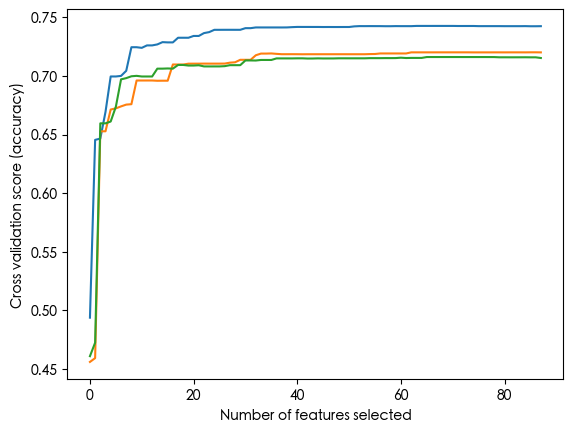

In [ ]:
# ================================ #
# ======  feature selection ====== #
# ================================ #
import matplotlib.pyplot as plt

y_vector = train_sample_df[target].astype(int).values.ravel()
x_matrix = train_sample_df[features].values

warnings.filterwarnings("ignore")
rfecv = RFECV(estimator=RidgeClassifierCV(), 
              step=1, 
              cv=3,
              n_jobs=10, 
              verbose=0,
              scoring='average_precision')
rfecv.fit(x_matrix, y_vector)
print("Optimal number of features : %d" % rfecv.n_features_)
feat_selection = []
for i,feature in enumerate(features):
    feat_selection.append({'name': feature,
                           'selected':rfecv.support_[i],
                           'ranking':rfecv.ranking_[i]})
feat_selection = pd.DataFrame(feat_selection)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(range(0, len(rfecv.grid_scores_)),rfecv.grid_scores_,)
plt.show()


In [ ]:
selected_features = list(feat_selection[feat_selection.ranking<=1].name.unique())
print(len(selected_features))

71


#### 7.3.3 Parameter search 

we test some parameter combinations based on the last results, and then we keep the best combination to the final fit, we also use the already filtered features `selected_features`

In [ ]:
# we test some combinations of parameters and check
models = {'LGBM_v1':HistGradientBoostingClassifier(),        
          'LGBM_v2':HistGradientBoostingClassifier(max_iter=50,max_leaf_nodes=10,max_depth=5, l2_regularization=0),        
          'LGBM_v3':HistGradientBoostingClassifier(max_iter=100,max_leaf_nodes=5,max_depth=10, l2_regularization=0),        
          'LGBM_v4':HistGradientBoostingClassifier(max_iter=100,max_leaf_nodes=15,max_depth=15, l2_regularization=0.5),        
          'LGBM_v5':HistGradientBoostingClassifier(max_iter=10,max_leaf_nodes=30,max_depth=20, l2_regularization=0.5),        
          'LGBM_v5':HistGradientBoostingClassifier(l2_regularization=0.5),        
        }


y_vector = train_sample_df[target].astype(int).values.ravel()
x_matrix = train_sample_df[selected_features].values

# ignore warnings 
import warnings
warnings.filterwarnings("ignore")

tscv  = model_selection.TimeSeriesSplit(n_splits = 3)
model_results = []
for mdl in models.keys():
    init_time = time.time()
    scores = model_selection.cross_validate(models[mdl],
                                            x_matrix,
                                            y_vector,
                                            scoring=['average_precision', # AUCPR https://stats.stackexchange.com/q/157012/274422
                                                     'roc_auc', # AUC
                                                     'f1',
                                                     ], 
                                            cv=tscv)
    aucpr = np.nanmean(scores['test_average_precision'])
    auc = np.nanmean(scores['test_roc_auc'])
    f1 = np.nanmean(scores['test_f1'])
    elapsed_time = time.time() - init_time
    model_results.append({'aucpr':aucpr,
                          'auc':auc,
                          'f1':f1,
                          'elapsed_time': elapsed_time,
                          'name':mdl})
    print(f"{mdl}, {aucpr = :.3f}, {auc = :.3f}, {f1 = :.3f}, {elapsed_time = :.1f}s")

results_df = pd.DataFrame(model_results) 

LGBM_v1, aucpr = 0.741, auc = 0.949, f1 = 0.663, elapsed_time = 28.2s
LGBM_v2, aucpr = 0.738, auc = 0.948, f1 = 0.660, elapsed_time = 8.8s
LGBM_v3, aucpr = 0.738, auc = 0.948, f1 = 0.661, elapsed_time = 10.6s
LGBM_v4, aucpr = 0.743, auc = 0.950, f1 = 0.664, elapsed_time = 18.2s
LGBM_v5, aucpr = 0.743, auc = 0.950, f1 = 0.666, elapsed_time = 29.2s


#### 7.3.4 final fit 
we fit the selected model with the selected features on the overall train dataframe 



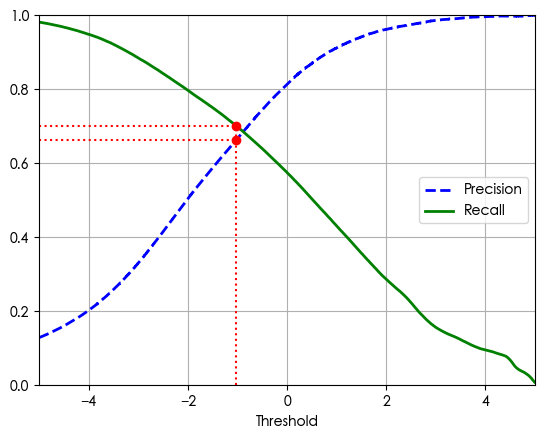

 70% recall:  threshold_70_recall = -1.0237205604471258, precisions_70_recall = 0.6625362362674434


In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import average_precision_score, roc_auc_score

y_vector = train_df[target].astype(int).values.ravel()
x_matrix = train_df[selected_features].values
y_test = test_df[target].astype(int).values.ravel()
x_test = test_df[selected_features].values

model = HistGradientBoostingClassifier(l2_regularization=0.5) #LGBM
y_scores = cross_val_predict(model, x_matrix, y_vector, cv=3, method='decision_function' ) 

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    precisions_70_recall = precisions[np.argmin(recalls >= 0.70)]
    threshold_70_recall = thresholds[np.argmin(recalls >= 0.70)]
    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold")
    plt.plot([threshold_70_recall, threshold_70_recall], [0., 0.7], "r:")
    plt.axis([-5, 5, 0, 1])
    plt.plot([-5, threshold_70_recall], [0.7, 0.7], "r:")
    plt.plot([-5, threshold_70_recall], [precisions_70_recall, precisions_70_recall], "r:")
    plt.plot([threshold_70_recall], [0.7], "ro") 
    plt.plot([threshold_70_recall], [precisions_70_recall], "ro")
    plt.grid(True)
    plt.legend()
    plt.show()
    print(f' 70% recall:  {threshold_70_recall = }, {precisions_70_recall = }')

precisions, recalls, thresholds = precision_recall_curve(y_vector, y_scores)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)



### 8.b 70% of recall 
once that the model is fitted we can estimate the score threshold that we will need to use in order to "detect" at least 70% of the `flux_extreme` events, this is the same as ask for a `70% recall`. To do that we will need to use a `score_threshold` of `-1.0237` and that will give us a precision of `0.66`.

As you can observe in the upper plot there is a trade-off between the precision and recall, usually a higher recall, comes with a decrease in precision.  

### 8.a Model performance 
As we explain in the model fitting chapter (7) we will be using AUCPR for the evaluation of this model, we perform the scoring using the `test_df` dataframe. 


In [ ]:
fitted_model =  model.fit(x_matrix, y_vector)
y_scores_test = fitted_model.predict_proba(x_test)[:, 1]
aucpr_score = average_precision_score(y_test, y_scores_test)
auc_score = roc_auc_score(y_test, y_scores_test)

print(f'{aucpr_score = :.3f} {auc_score = :.3f}')

aucpr_score = 0.739 auc_score = 0.962


to determinate the features importance we use the permutation feature importance described on [Sklearn Documentation]
(https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-feature-importance)

There is a [strong criticizing](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py) of using the traditional MDI metrics to determinate the feature importance. [Ref](https://github.com/scikit-learn/scikit-learn/issues/15132)


In [ ]:

from sklearn.inspection import permutation_importance
r = permutation_importance(fitted_model, x_matrix, y_vector,
                           n_repeats=3,
                           random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{selected_features[i]:<8}    "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")



ft_rolling_sum_flux_extreme_d1    0.005 +/- 0.000
ft_rolling_sum_temp_max_d1    0.003 +/- 0.000
ft_rolling_sum_flux_extreme_d7    0.003 +/- 0.000
ft_rolling_sum_flux_extreme_d3    0.002 +/- 0.000
ft_rolling_sum_flux_extreme_d28    0.002 +/- 0.000
ft_rolling_sum_precip_d1    0.001 +/- 0.000
ft_rolling_avg_precip_d365    0.001 +/- 0.000
ft_rolling_sum_flux_d1    0.001 +/- 0.000
ft_rolling_sum_flux_extreme_d365    0.001 +/- 0.000
ft_rolling_sum_precip_d3    0.001 +/- 0.000
ft_rolling_sum_precip_d7    0.001 +/- 0.000
ft_rolling_sum_precip_extreme_d1    0.000 +/- 0.000
ft_rolling_sum_flux_extreme_d14    0.000 +/- 0.000
ft_num_month    0.000 +/- 0.000
ft_rolling_sum_flux_extreme_d100    0.000 +/- 0.000
ft_rolling_sum_temp_max_d28    0.000 +/- 0.000
ft_rolling_avg_precip_d28    0.000 +/- 0.000
ft_rolling_sum_flux_d14    0.000 +/- 0.000
ft_rolling_avg_temp_max_d365    0.000 +/- 0.000
ft_rolling_avg_temp_max_d14    0.000 +/- 0.000
ft_rolling_sum_temp_max_d7    0.000 +/- 0.000
ft_rolling_sum_tem

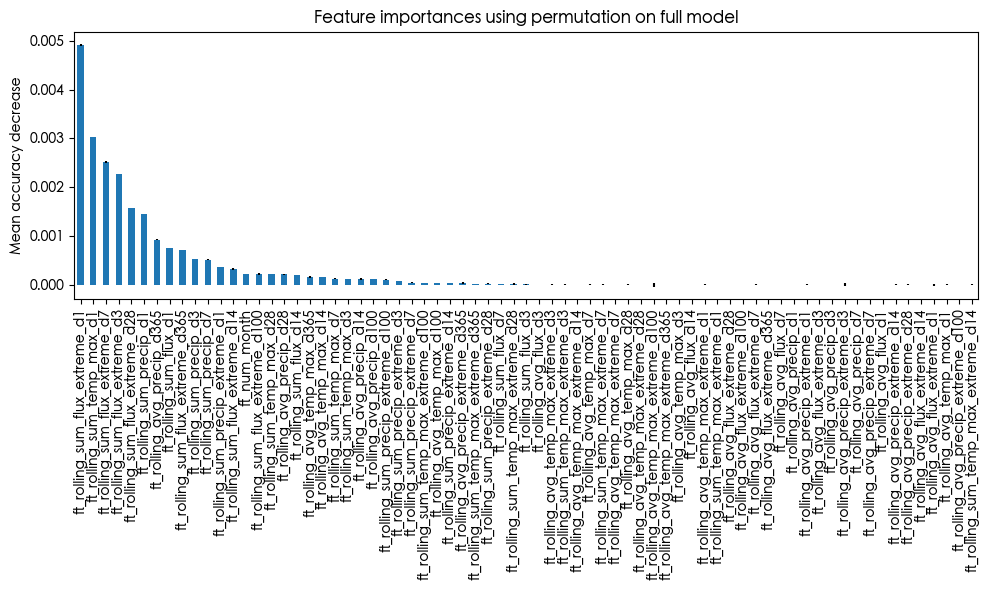

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
features_importances = pd.Series(r.importances_mean, index=selected_features)
features_importances.sort_values(inplace=True, ascending=False)
features_importances.plot.bar(yerr=r.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()


## Conclusions

Given that we are predicting the occurrence of extreme flux events there are a few things that might be prompting these very good results, I probably will focus on the fact that there is a strong probability that a `flux_extreme` event will last more than a few days, therefore our model might be very good at predicting what is the probability of a consecutive day of event rather than predicting what is the probability of an event occurring for the first day. Changing the `target` variable with that end probably will provide a more useful model and more realistic one. 

## further investigation 

Given the time constraints of this assignment, it was not possible to test the hypothesis of the decrease in `flux_extreme` events in a robust manner, we did have a signal from the lineal model that uses the percentage of events but is possible that we will need to use a more robust methodology to that end. The methodology proposed provides a solution in that direction  

Also, we didn't perform a very accurate or robust hyperparameter optimization on the final "classificator". Is very common that this hyperparameter search only improves the model marginally compared to better feature eng or data selection.